# SIIM-ISIC Melanoma Classification




O [câncer de pele](https://saude.gov.br/saude-de-a-z/cancer-de-pele) é um grave problema de saúde, sendo o tipo de câncer mais comum no Brasil e no mundo. Dentro das categorias de câncer de pele, o Melanoma é o tipo mais perigoso por sua alta possibilidade de ocasionar metástase e se espalhar para outros órgãos.

A competição [SIIM-ISIC Melanoma Classification](https://www.kaggle.com/c/siim-isic-melanoma-classification) tem o objetivo de classificar em benigna e maligna várias imagens suspeitas de possuir câncer de pele Melanoma. A submissão deve conter um arquivo .csv com uma coluna de dados referente ao nome das imagens e outra com as respectivas probabilidades de cada imagem conter uma amostra maligna.

A base é composta por 33126 imagens de treinamento e 10982 imagens de teste. E também por dois arquivos .csv com algumas informações sobre os pacientes de cada imagem.

## Análise da base de dados

Para todos os exemplos testados nesse notebook, admitimos que os arquivos train.csv, test.csv e as pastas /train e /test com as imagens .jpg estão no mesmo diretório que esse código.

Primeiramente, devemos ler os arquivos .csv com as informações da base.

In [ ]:
import pandas as pd

# Leitura dos dataframes dos arquivos csv
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

Características do arquivo de treinamento.

In [ ]:
train_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Vemos que esse dataset possui as informações:

* image_name: Nome da imagem referente a esse exemplo de treinamento.
* patient_id: ID do paciente.
* sex: Sexo do paciente.
* age_approx: Idade aproximada do paciente
* anatom_site_general_challenge: Parte do corpo onde a foto foi tirada.
* diagnosis: Dianóstico.
* benign_malignant: Classificação da mancha em maligna ou benigna.
* target: 0 (benigno), 1 (maligno).

Características do arquivo de teste.

In [ ]:
test_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


O arquivo de dados de teste possui quase as mesmas informações que o de treinamento, exceto as últimas colunas (diagnosis, benign_malignant, target), as quais queremos inferir.

Um dado interessante a ser observado em qualquer base é a distribuição dos exemplos em cada classe.

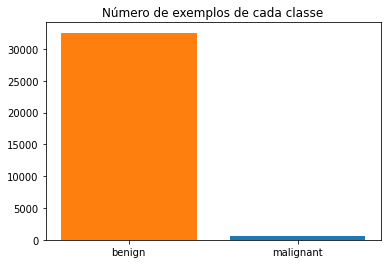

Número de exemplos benignos: 32542
Número de exemplos malignos: 584


In [ ]:
import matplotlib.pyplot as plt

labels=train_data['benign_malignant'].value_counts().index
values=train_data['benign_malignant'].value_counts().values

plt.title('Número de exemplos de cada classe')
nclasses = plt.bar(labels, values)
nclasses[0].set_color('tab:orange')
plt.show()

print("Número de exemplos benignos: {}".format(values[0]))
print("Número de exemplos malignos: {}".format(values[1]))

Vemos que essa base possui um forte desbalanceamento, essa característica é muito importante e irá influenciar a maneira como os modelos de redes neurais serão treinados.

Também é interessante visualizar algumas das imagens de ambas as classes para verificar as características de manchas que são Melanoma e manchas que não são Melanomas.

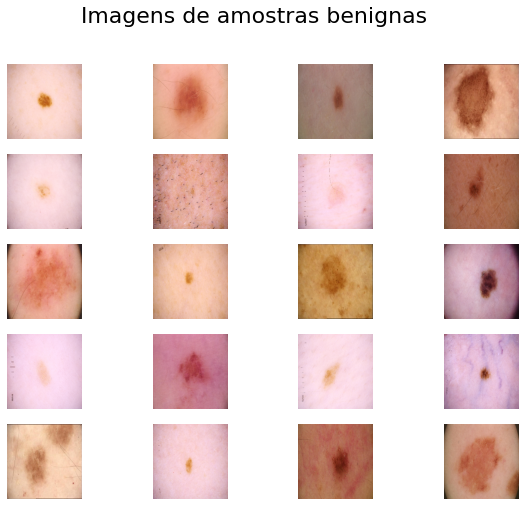

In [ ]:
import cv2
import numpy as np

benign_samples = train_data[train_data['benign_malignant']=='benign'].sample(20)

fig, ax = plt.subplots(5,4, figsize=(10,8))

for i in range(len(benign_samples)):
    img=cv2.imread(str("train/" + benign_samples['image_name'].iloc[i]+'.jpg'))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    ax[i//4, i%4].imshow(img)
    ax[i//4, i%4].axis('off')

fig.suptitle('Imagens de amostras benignas', fontsize=22)       
plt.show()

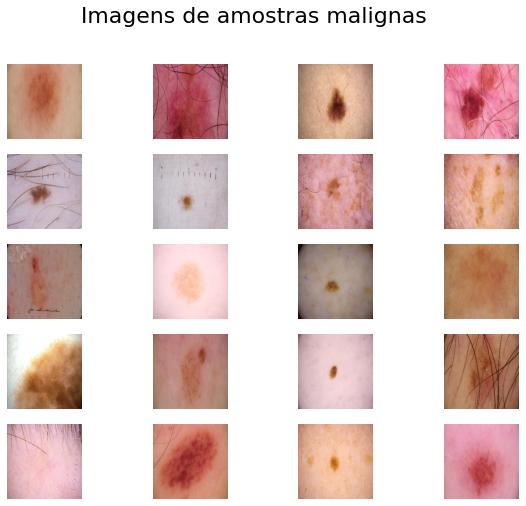

In [ ]:
malignant_samples = train_data[train_data['benign_malignant']=='benign'].sample(20)
fig, ax = plt.subplots(5,4, figsize=(10,8))

for i in range(len(malignant_samples)):
    img=cv2.imread(str("train/" + malignant_samples['image_name'].iloc[i]+'.jpg'))
    img = cv2.resize(img, (224,224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    ax[i//4, i%4].imshow(img)
    ax[i//4, i%4].axis('off')
        
fig.suptitle('Imagens de amostras malignas', fontsize=22)       
plt.show()

Para uma pessoa sem treinamento proficional, identificar se uma amostra é maligna ou benigna é bastante difícil.

## Avaliação e score

Quando treinamos um modelo que será usado para fazer inferências é essencial estabelecer quais métricas serão usadas para avaliá-lo.

O score oficial usado para testar as submissões na competição é a área abaixo da curva ROC das probabilidades preditas e os valores esperados.

### Curva ROC e AUC

A curva ROC (Curva Característica de Operação do Receptor) é uma forma de representar os resultados de desempenho de um classificador baseado em parâmetros de taxa de resultados "Verdadeiro Positivo" e "Falso Positivo".

Temos que:

>$Taxa De Verdadeiros Positivos = \frac{Verdadeiros Positivos}{Verdadeiros Positivos + Falsos Negativos}$

>$Taxa De Falsos Positivos = \frac{Falsos Positivos}{Falsos Positivos + Verdadeiros Negativos}$

Para representação gráfica, são consideradas essas taxas referentes à diferentes valores de threshold do classificador, aumentando e/ou diminuindo os valores esperados como positivos ou negativos.

Como ilustrado na imagem abaixo, temos a curva ROC representada a partir de diferentes pontos de treshhold do classificador (pontos A, B e C).

<img src="https://drive.google.com/uc?id=1mA6SJEf27PR9VJVfonuCqKHED4yMknjP">

Esse tipo de representação é extremamente útil para avaliação de aplicações que trabalham em um ambiente com uma grande desproporção entre classes, possibilitando a consideração de um "custo/benefício" para os erros/acertos do classificador.

E com o intuito de simplificar e quantizar o desempenho de um classificador representado no gráfico de curva ROC, é utilizado a área abaixo da curva ROC, chamada de AUC, como métrica. Seu valor pode variar entre 0 e 1, sendo que quanto maior for seu valor, melhor será o classificador.



## Construindo um simples modelo

A primeira submissão para a competição tinha o objetivo de testar um modelo simples e verificar aproximadamente quanto tempo demoraria para a sua execução, com isso avaliaríamos a viabilidade de lidar com essa base tão extensa.

In [ ]:
# Imports
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense


from tensorflow.keras.metrics import TruePositives
from tensorflow.keras.metrics import FalsePositives
from tensorflow.keras.metrics import TrueNegatives
from tensorflow.keras.metrics import FalseNegatives
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import AUC

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_auc_score

Primeiramente carregamos os aquivos de informações e adicionamos a extensão de formato das imagens às colunas image_name.

In [ ]:
# Leitura dos dataframes dos arquivos csv
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Adicionando a extensão aos nomes das imagens
train_data['image_name'] = train_data['image_name'].astype(str)+".jpg"
test_data['image_name'] = test_data['image_name'].astype(str)+".jpg"

Para lidar com imagens, o Keras possui a ferramenta [ImageDataGenerator](https://keras.io/api/preprocessing/image/). Essa classe foi criada para lidar com grandes bases de dados de imagens e permite um carregamento em pacotes de imagens para gerar menos impacto na memória RAM do computador. Além disso, ainda faz o pré-processamento das imagens, colocando-as em um determinado tamanho e podendo até mesmo aplicar filtros e outros métodos de visão computacional.

Para facilitar ainda mais, essa classe possui o método [flow_from_dataframe](https://keras.io/api/preprocessing/image/#flowfromdataframe-method), que faz o carregamento das imagens por meio de dados de um dataframe pandas.

Nessa primeira submissão, escolhemos um tamanho de imagem pequeno de 32x32 pixels.

In [ ]:
image_height = 32
image_width = 32
batch_size = 32

# Carregando as imagens de treinamento com ImageDataGenerator
image_datagen = ImageDataGenerator(rescale = 1./255,          # normaliza valores dos pixels da imagem entre 0-1
                                   validation_split = 0.3)    # divide os dados do dataset em uma proporção de treinamento e validação


train_generator = image_datagen.flow_from_dataframe(dataframe=train_data,                   # dataframe com dados da imagem
                                                    directory="train",                      # diretório com as imagens
                                                    x_col="image_name",                     # nome da coluna do dataframe com os nomes das imagens
                                                    y_col="benign_malignant",               # nome da coluna do dataframe com a especificação das classes
                                                    class_mode="binary",                    # modo binário, irá selecionar as imagens em duas classes
                                                    target_size=(image_height,image_width), # tamanho das imagens de treinamento
                                                    batch_size=batch_size,                  # quantidade de imagens por pacote
                                                    subset="training",                      # subset de treinamento ou validação
                                                    color_mode="rgb")                       # modo de carregamento da imagem em 3 canais RGB

validation_generator = image_datagen.flow_from_dataframe(dataframe=train_data,
                                                         directory="train",
                                                         x_col="image_name",
                                                         y_col="benign_malignant",
                                                         class_mode="binary",
                                                         target_size=(image_height,image_width),
                                                         batch_size=batch_size,
                                                         subset="validation",
                                                         color_mode="rgb")



Found 23189 validated image filenames belonging to 2 classes.
Found 9937 validated image filenames belonging to 2 classes.


Em seguida, construimos um modelo simples, com apenas uma camada de convolução usando a biblioteca Keras. 

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(7,7), input_shape=(32,32,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())
model.add(Dense(units = 100, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 545,737
Trainable params: 545,737
Non-trainable params: 0
_________________________________________________________________


Para compilar o nosso modelo, escolhemos o otimizador [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) e a funcão de loss [binary_crossentropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class).

Para avaliar o nosso modelo durante o treinamento, iremos observar:

* True Positives: amostras com cancer corretamente classificadas.
* False Positives: amostras sem cancer erroneamente classificadas.
* True Negatives: amostras sem cancer corretamente classificadas.
* False Negatives: amostras com cancer erroneamente classificadas.
* Binary Accuracy: Acurácia do modelo.
* Precision: Precisão do modelo.
* Recall: Revocação do modelo.
* AUC: Área aproximada abaixo da curva ROC

In [ ]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
]

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = METRICS)

Para fazer o treinamento, é útil usar uma função de callback para parar esse treinamento quando o modelo não está mais evoluindo. Por isso, utilizaremos a função [EarlyStopping](https://keras.io/api/callbacks/early_stopping/), que irá acompanhar a medida AUC do dataset de validação ('val_auc').

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

Para fazer o treinamento, usamos o método fit com as imagens de treinamento e validação. O parâmetro workers faz paralelização do processamento quando múltiplos cores de processamento estão disponíveis.

In [ ]:
# Fazer o Treinamento
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=validation_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=50,
          callbacks=early_stopping,
          workers = 16)

model.save_weights('simple_model_weights.h5')

Epoch 1/50
724/724 [==============================] - 320s 442ms/step - loss: 0.0926 - tp: 1.0000 - fp: 31.0000 - tn: 22720.0000 - fn: 405.0000 - accuracy: 0.9812 - precision: 0.0312 - recall: 0.0025 - auc: 0.6217 - val_loss: 0.0875 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 9743.0000 - val_fn: 177.0000 - val_accuracy: 0.9822 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7200
Epoch 2/50
724/724 [==============================] - 306s 422ms/step - loss: 0.0871 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 22751.0000 - fn: 406.0000 - accuracy: 0.9825 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6664 - val_loss: 0.0847 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 9743.0000 - val_fn: 177.0000 - val_accuracy: 0.9822 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7414
Epoch 3/50
724/724 [==============================] - 300s 415ms/step - loss: 0.0871 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 22751.0000 - fn: 406.0000 - accuracy: 0.9825

Antes de fazer a inferência dos dados de teste, vamos analisar o resultado nos dados de validação.

In [ ]:
validation_predictions = model.predict(validation_generator,
                                       verbose=1,
                                       workers=16)

311/311 [==============================] - 86s 278ms/step


Usamos o cálculo do score AUC da biblioteca scikitLearn para obter um resultado mais fiel dessa estatística.

In [ ]:
val_auc = roc_auc_score(y_true = validation_generator.classes, y_score=validation_predictions)
print(val_auc)

0.5018135824766139


Para visualizar graficamente, construimos a matriz de confusão das predições de validação.

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, title):
    acc = accuracy_score(y_true, y_pred)
    title = title + " (Acurácia: " + str("{:10.4f}".format(acc)) + ")"

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)
    plt.figure(figsize=(5.5,4))
    sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
    plt.title(title)
    plt.ylabel('Label verdadeira')
    plt.xlabel('Label predita')
    plt.show()


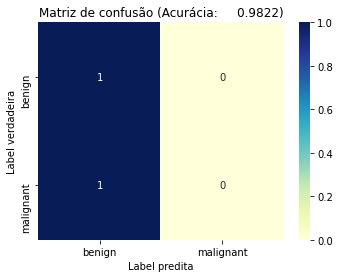

In [ ]:
# Plota a matriz de confusão dos dados de validação
plot_confusion_matrix(validation_generator.classes,
                      (validation_predictions>0.5).astype(int),
                      ['benign','malignant'], "Matriz de confusão")

Como podemos ver, apesar de apresentar uma alta acurácia, o modelo não classificou nenhuma imagem como melanoma. Isso provavelmente se deve a simplicidade do modelo, redução massiva do tamanho das imagens e ao grande desbalanceamento da base.

Para fazer a primeira submissão, inferimos os dados de teste.

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                  directory="test",
                                                  x_col="image_name",
                                                  y_col=None,
                                                  class_mode=None,
                                                  target_size=(image_height,image_width),
                                                  batch_size=batch_size)

# Realiza predição
predictions = model.predict(test_generator,
                            verbose=1,
                            workers=16)

Found 10982 validated image filenames.
344/344 [==============================] - 98s 285ms/step


In [ ]:
submission = pd.DataFrame(test_data['image_name'].str.replace(r'.jpg', ''))
submission['target']=predictions

# Cria arquivo de submissão
submission.to_csv('simple_model_submission.csv',index=False)

O score oficial dessa submissão foi 0.506.

## Modelo de rede neural VGG

A segunda submissão tinha como objetivo implementar um modelo de classificação de imagem já testado em bases de classificação famosas, uma rede neural [VGG](https://becominghuman.ai/what-is-the-vgg-neural-network-a590caa72643).

Nossa implementação possui uma arquitetura semelhante a VGG Network, usando várias camadas de convolução seguidas de camadas de pooling, criando uma rede neural convolucional profunda.

Essa rede terá como entrada imagens de 224x224 pixels.

In [ ]:
# Carregamento das imagens

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data['image_name'] = train_data['image_name'].astype(str)+".jpg"
test_data['image_name'] = test_data['image_name'].astype(str)+".jpg"

batch_size = 16       # Tamanho do pacote
image_height = 224    # Altura da imagem
image_width = 224     # Largura da imagem

# Realiza as augmentações nas imagens
image_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.3)

train_generator = image_datagen.flow_from_dataframe(dataframe=train_data,
                                                    directory="train",
                                                    x_col="image_name",
                                                    y_col="benign_malignant",
                                                    class_mode="binary",
                                                    target_size=(image_height,image_width),
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    color_mode="rgb")

validation_generator = image_datagen.flow_from_dataframe(dataframe=train_data,
                                                         directory="train",
                                                         x_col="image_name",
                                                         y_col="benign_malignant",
                                                         class_mode="binary",
                                                         target_size=(image_height,image_width),
                                                         batch_size=batch_size,
                                                         subset="validation",
                                                         color_mode="rgb")

Found 23189 validated image filenames belonging to 2 classes.
Found 9937 validated image filenames belonging to 2 classes.


In [ ]:
# Criação do modelo

model = Sequential()
model.add(Conv2D(input_shape=(image_height,image_width,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1, activation="softmax"))
model.summary()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = METRICS)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 256)      

In [ ]:
# Realiza treinamento

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=validation_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=50,
          callbacks=early_stopping,
          workers = 16)

model.save_weights('vgg_model_weights.h5')

Epoch 1/50
1449/1449 [==============================] - 349s 241ms/step - loss: 14.9815 - tp: 407.0000 - fp: 22766.0000 - tn: 9743.0000 - fn: 177.0000 - accuracy: 0.3067 - precision: 0.0176 - recall: 0.6969 - auc: 0.5230 - val_loss: 14.9775 - val_tp: 177.0000 - val_fp: 9759.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0178 - val_precision: 0.0178 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 2/50
1449/1449 [==============================] - 362s 250ms/step - loss: 14.9815 - tp: 407.0000 - fp: 22766.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0176 - precision: 0.0176 - recall: 1.0000 - auc: 0.5000 - val_loss: 14.9775 - val_tp: 177.0000 - val_fp: 9759.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0178 - val_precision: 0.0178 - val_recall: 1.0000 - val_auc: 0.5000
Epoch 3/50
1449/1449 [==============================] - 360s 249ms/step - loss: 14.9815 - tp: 407.0000 - fp: 22766.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0176 - precis

Como podemos perceber pela saída do método fit, as métricas de avaliação do modelo não mudaram com o passar das épocas. Isso indica que o modelo não convergiu, isso pode ser ter sido causado pela alta quantidade de camadas, pelo grande desbalanceamento da base, pela função de loss. 

Pelos testes realizados, mudar parâmetros como função de loss, tamanho do batch das imagens e função de saída da última camada densa não foram suficientes para evitar a não convergência.

In [ ]:
validation_predictions = model.predict(validation_generator,
                                       verbose=1,
                                       workers=16)

622/622 [==============================] - 94s 152ms/step


In [ ]:
val_auc = roc_auc_score(y_true = validation_generator.classes, y_score=validation_predictions)
print(val_auc)

0.5


A medida AUC dos dados de validação deu exatamente 0.5, indicando que o modelo pode estar classificando todos os exemplos em apenas uma classe.


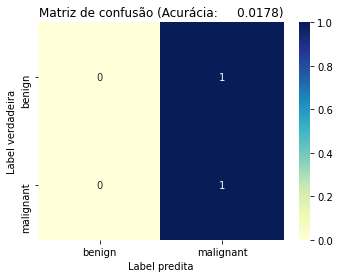

In [ ]:
# Plota a matriz de confusão dos dados de validação
plot_confusion_matrix(validation_generator.classes,
                      (validation_predictions>0.5).astype(int),
                      ['benign','malignant'], "Matriz de confusão")

Nesse caso, estranhamente todos os elementos foram classificados como malignos, confirmando a não convergência do modelo.

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                  directory="test",
                                                  x_col="image_name",
                                                  y_col=None,
                                                  class_mode=None,
                                                  target_size=(image_height,image_width),
                                                  batch_size=batch_size)

predictions = model.predict(test_generator,
                            verbose=1,
                            workers=16)


submission = pd.DataFrame(test_data['image_name'].str.replace(r'.jpg', ''))
submission['target'] = predictions

submission.to_csv('vgg_model_submission.csv',index=False)

Found 10982 validated image filenames.
687/687 [==============================] - 104s 151ms/step


O score oficial dessa submissão foi 0.500.

## Tentativa de realizar o pré-processamento da base e reduzir o desbalanceamento

Vimos que aumentar a complexidade do modelo não alterou a eficácia em predizer os pacientes com tumor maligno.

Um palpide de porque o modelo está enviesado é o grande desbalanceamento da base, que tentaremos corrigir utilizando pesos para as classes. Também tentaremos melhorar o pré-processamento das bases usando [augmentations](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/). Dessa forma a cada época as imagens de treinamento e validação serão um pouco diferentes das anteriores, adicionando uma certa aleatoriedade ao processo de treinamento.



In [ ]:
# Carregamento das imagens
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data['image_name'] = train_data['image_name'].astype(str)+".jpg"
test_data['image_name'] = test_data['image_name'].astype(str)+".jpg"


batch_size = 16       # Tamanho do pacote
image_height = 224    # Altura da imagem
image_width = 224     # Largura da imagem

# Realiza as augmentações nas imagens
image_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.3,
                                   rotation_range=30,      # Rotaciona aleatóriamente imagens em 30 graus
                                   zoom_range=0.15,        # Zoom aleatório
                                   width_shift_range=0.2,  # Shift de largura aleatório
                                   height_shift_range=0.2, # Shift de altura aleatório
                                   horizontal_flip=True)   # Flip horizontal aleatório

train_generator = image_datagen.flow_from_dataframe(dataframe=train_data,
                                                    directory="train",
                                                    x_col="image_name",
                                                    y_col="benign_malignant",
                                                    class_mode="binary",
                                                    target_size=(image_height,image_width),
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    color_mode="rgb")

validation_generator = image_datagen.flow_from_dataframe(dataframe=train_data,
                                                         directory="train",
                                                         x_col="image_name",
                                                         y_col="benign_malignant",
                                                         class_mode="binary",
                                                         target_size=(image_height,image_width),
                                                         batch_size=batch_size,
                                                         subset="validation",
                                                         color_mode="rgb")

Found 23189 validated image filenames belonging to 2 classes.
Found 9937 validated image filenames belonging to 2 classes.


Para esse teste usaremos uma outra arquitetura de rede famosa, a [ResNet](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035). A ela, adicionamos uma camada densa com um neurônio que dará a probabilidade em estudo.

In [ ]:
# Criação do modelo

from tensorflow.keras.applications.resnet50 import ResNet50
# load model

model = Sequential()
model.add(ResNet50(input_shape=(image_height, image_width, 3), classes=2,include_top=False, weights=None))
model.add(Flatten())
model.add(Dense(units=1, activation="sigmoid"))


# summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 100353    
Total params: 23,688,065
Trainable params: 23,634,945
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = METRICS)

Calcula os pesos de cada classe.

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes)

class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
print(class_weights)

{0: 0.5089324905627249, 1: 28.487714987714988}


In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_data=validation_generator,
          validation_steps=STEP_SIZE_VALID,
          epochs=50,
          callbacks=early_stopping,
          workers = 16,
          class_weight=class_weights)

model.save_weights('class_weights_balanced_weights.h5')

Epoch 1/50
1449/1449 [==============================] - 346s 239ms/step - loss: 20.1974 - tp: 337.0000 - fp: 17373.0000 - tn: 5393.0000 - fn: 70.0000 - accuracy: 0.2473 - precision: 0.0190 - recall: 0.8280 - auc: 0.5805 - val_loss: 936.9044 - val_tp: 72.0000 - val_fp: 4882.0000 - val_tn: 4877.0000 - val_fn: 105.0000 - val_accuracy: 0.4981 - val_precision: 0.0145 - val_recall: 0.4068 - val_auc: 0.4731
Epoch 2/50
1449/1449 [==============================] - 365s 252ms/step - loss: 13.3197 - tp: 355.0000 - fp: 19884.0000 - tn: 2883.0000 - fn: 51.0000 - accuracy: 0.1397 - precision: 0.0175 - recall: 0.8744 - auc: 0.5081 - val_loss: 1.1988 - val_tp: 176.0000 - val_fp: 9260.0000 - val_tn: 499.0000 - val_fn: 1.0000 - val_accuracy: 0.0679 - val_precision: 0.0187 - val_recall: 0.9944 - val_auc: 0.4980
Epoch 3/50
1449/1449 [==============================] - 352s 243ms/step - loss: 20.5082 - tp: 346.0000 - fp: 18201.0000 - tn: 4566.0000 - fn: 60.0000 - accuracy: 0.2120 - precision: 0.0187 - recal

In [ ]:
validation_predictions = model.predict(validation_generator,
                                       verbose=1,
                                       workers=16)

622/622 [==============================] - 107s 173ms/step


In [ ]:
val_auc = roc_auc_score(y_true = validation_generator.classes, y_score=validation_predictions)
print(val_auc)

0.5150695795128276


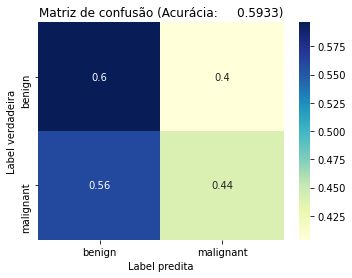

In [ ]:
# Plota a matriz de confusão dos dados de validação
plot_confusion_matrix(validation_generator.classes,
                      (validation_predictions>0.5).astype(int),
                      ['benign','malignant'], "Matriz de confusão")

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                  directory="test",
                                                  x_col="image_name",
                                                  y_col=None,
                                                  class_mode=None,
                                                  target_size=(image_height,image_width),
                                                  batch_size=batch_size)

predictions = model.predict(test_generator,
                            verbose=1,
                            workers=16)


submission = pd.DataFrame(test_data['image_name'].str.replace(r'.jpg', ''))
submission['target'] = predictions

submission.to_csv('class_weight_balanced_submission.csv',index=False)

Found 10982 validated image filenames.
687/687 [==============================] - 105s 153ms/step


O score oficial dessa submissão foi 0.489.

## Usando um modelo pré-treinado como extrator de features

Uma estratégia comum nas aplicações de redes neurais ultimamente é a transferência de aprendizado ou 'transfer learning'. Nessa estratégia, um modelo treinado para uma finalidade é utilizado para tentar inferir exemplos de problemas diferentes. Em outras palavras, consiste em utilizar recursos aprendidos em um problema prévio e aproveitá-lo em um novo problema semelhante.

A rede treinada já entrou em contato com várias imagens de várias classes e seus pesos já foram usados em alguma tarefa e trouxeram resultados satisfatórios. As camadas de convolução dessa rede já estão especialistas em encontrar certos tipos de features das imagens.

Sendo assim, podemos utilizar tais pesos para treinar um dataset que, a principio, tem poucos dados para que seja feito um treinamento do zero ou, simplesmente, com o intuito de poupar tempo/custo de processamento.

Para fazer a transferência de aprendizado, usa-se apenas as camadas convolucionais da rede já treinada e adiciona a esse modelo um classificador. 

A sua base de dados irá passar pelas camadas convolucionais da rede treinada e na prática ocorrerá a extração de features das suas imagens. O seu classificador irá usar essas features e tentar acertar a a classe correta.

A partir dos diversos tipos de redes pré-treinadas, é possível verificar o desempenho alcançado por cada rede em comparativos relacionados às suas taxas de acurácia, como ilustrado abaixo. 

![texto alternativo](https://drive.google.com/uc?id=10wTfPtfhae6DGINgY-zTzTYhGP3qNM1w)
[Fonte](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet)

In [ ]:
# Leitura dos dataframes dos arquivos csv
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Adicionando a extensão aos nomes das imagens
train_data['image_name'] = train_data['image_name'].astype(str)+".jpg"
test_data['image_name'] = test_data['image_name'].astype(str)+".jpg"


In [ ]:
# Carregamento das imagens
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data['image_name'] = train_data['image_name'].astype(str)+".jpg"
test_data['image_name'] = test_data['image_name'].astype(str)+".jpg"


batch_size = 32       # Tamanho do pacote
image_height = 224    # Altura da imagem
image_width = 224     # Largura da imagem

# Realiza as augmentações nas imagens
image_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,      
                                   zoom_range=0.15,        
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2, 
                                   horizontal_flip=True)   

# Nesse treinamento, todas as imagens serão usadas como dataset de treinamento
train_generator = image_datagen.flow_from_dataframe(dataframe=train_data,
                                                    directory="train",
                                                    x_col="image_name",
                                                    y_col="benign_malignant",
                                                    class_mode="binary",
                                                    target_size=(image_height,image_width),
                                                    batch_size=batch_size, subset="training",
                                                    color_mode="rgb")

Found 33126 validated image filenames belonging to 2 classes.


In [ ]:
import efficientnet.tfkeras as efn
# load model

model = Sequential([
        efn.EfficientNetB0(
            input_shape=(image_height, image_width, 3),
            weights='imagenet',
            include_top=False
        ),
        GlobalAveragePooling2D(),
        Dense(1, activation='sigmoid')
    ])



# summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = METRICS)

In [ ]:
early_stopping = EarlyStopping(
    monitor='auc', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size

model.fit(train_generator,
          steps_per_epoch=STEP_SIZE_TRAIN,
          epochs=50,
          callbacks=early_stopping,
          workers = 16)

Epoch 1/50
1035/1035 [==============================] - 350s 339ms/step - loss: 0.0829 - tp: 1.0000 - fp: 28.0000 - tn: 32483.0000 - fn: 582.0000 - accuracy: 0.9816 - precision: 0.0345 - recall: 0.0017 - auc: 0.767416s - loss: 0.0835 - tp: 1.0000 - fp: 28.0000 - tn: 30969.0000 - fn:
Epoch 2/50
1035/1035 [==============================] - 355s 343ms/step - loss: 0.0780 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 32511.0000 - fn: 583.0000 - accuracy: 0.9824 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7996
Epoch 3/50
1035/1035 [==============================] - 352s 340ms/step - loss: 0.0755 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 32510.0000 - fn: 584.0000 - accuracy: 0.9824 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8257
Epoch 4/50
1035/1035 [==============================] - 350s 338ms/step - loss: 0.0747 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 32511.0000 - fn: 583.0000 - accuracy: 0.9824 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8315
Epoch 5/50
1035/1035 [=

Epoch 00034: early stopping


In [ ]:
model.save_weights('tranfer_learning_weights.h5')

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_data,
                                                  directory="test",
                                                  x_col="image_name",
                                                  y_col=None,
                                                  class_mode=None,
                                                  target_size=(image_height,image_width),
                                                  batch_size=batch_size)

predictions = model.predict(test_generator,
                            verbose=1,
                            workers=16)


submission = pd.DataFrame(test_data['image_name'].str.replace(r'.jpg', ''))
submission['target'] = predictions

submission.to_csv('effnet3_model_submission.csv',index=False)

Found 10982 validated image filenames.
344/344 [==============================] - 103s 298ms/step


O score oficial dessa submissão foi 0.523.

## Rede neural multi-input

Sabemos que essa base de dados, além das imagens, possui um dataframe com informações sobre o paciente referente a cada imagem de melanoma. Assim, é natural imaginar um método que utilize os dois tipos de informação para a classificação. Dessa forma, foi criada uma rede neural que recebe duas entradas, imagem e dataframe, para gerar a classificação.

In [ ]:
# Imports
from pathlib import Path

from tensorflow.data import Dataset
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

Para que a rede neural receba duas entradas diferentes, essas entradas precisam estar em um formato compatível entre si. Assim, foi criada a classe MixedDataGenerator para gerar a entrada mista da rede neural.

Essa classe permite que os dados sejam carregados na memória em pequenos pacotes e os pacotes são carregados iterativamente durante os processos de treinamento, validação e predição. Dessa forma, não é necessário carregar os dados todos de uma única vez, gerando menos impacto na memória RAM do computador.

In [ ]:
class MixedDataGenerator(utils.Sequence):

    def __init__(self, values: pd.DataFrame,
                images: pd.Series, directory: str, labels: pd.Series=None,
                target_size: tuple=(32,32), batch_size: int=32, shuffle: bool=True):
        'Inicialização'

        self.values = values
        self.labels = labels
        self.images = images
        self.directory = Path(directory)
        self.target_size = target_size
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_files = images.count()
        self.columns = self.values.columns
        self.indices = None
        self.values_gen = ImageDataGenerator()
        self.labels_indices = None
        if labels is not None:
            self.labels_indices = list(self.labels.unique())

        self.on_epoch_end()

    
    def __len__(self):
        'Indica a quantidades de pacotes por épocas'

        return (self.num_files + self.batch_size - 1) // self.batch_size

    
    def __getitem__(self, index):
        'Gera um pacote de dados'

        # Gera os índices do pacote
        if index >= len(self):
            raise ValueError('Asked to retrieve element {index}, '
                             'but the Sequence '
                             'has length {length}'.format(index=index,
                                                          length=len(self)))
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        x_images = [self.__process_image(image) for image in self.images.loc[indices]]
        images = np.array(x_images)
        x_values = self.values.loc[indices]
        values = np.array(x_values)
        if self.labels is not None:
            y_labels = [self.labels_indices.index(label) for label in self.labels.loc[indices]]
            labels = np.eye(len(self.labels_indices))[y_labels]
        # Gera os dados
        if self.labels is not None:
            return [images, values], labels
        else:
            return [images, values]


    def on_epoch_end(self):
        'Atualiza os índices após cada época'

        self.indices = np.arange(len(self.values))
        if self.shuffle:
            np.random.shuffle(self.indices)

    
    def __process_image(self, image_name):
        'Lê a imagem da memória'

        image = load_img(Path(self.directory, image_name), target_size=self.target_size)
        image = self.values_gen.apply_transform(image, dict(rescale=1./255))            # normaliza valores dos pixels da imagem entre 0-1
        array = img_to_array(image)
        image.close()

        return array

Alguns exemplos do dataframe possuem dados faltantes nas colunas 'sex', 'age_approx' e 'anatom_site_general_challenge'. Assim, foi feita uma função para tratar esses dados. 

Como os exemplos com dados faltante nas colunas 'sex' e 'age_approx' eram poucos, e estes só existiam no conjunto de treinamento, foram simplesmente removidos. 

Com relação ao atributo 'anatom_site_general_challenge', foi criada uma nova categoria chamada 'unknown' (desconhecido), e os dados faltantes foram substituídos por essa categoria.

In [ ]:
def treatNan(data):
    # remove nan na coluna 'sex'
    data = data[data.sex == data.sex]
    # remove nan na coluna 'age_approx'
    data = data[data.age_approx == data.age_approx]

    # substitui nan na coluna 'anatom_site_general_challenge' pelo atributo 'unknown'
    data.anatom_site_general_challenge.fillna(value='unknown', inplace=True)

    return data

### Leitura dos dados

In [ ]:
# Leitura dos dataframes dos arquivos csv
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Adicionando a extensão aos nomes das imagens
train_data['image_name'] = train_data['image_name'].astype(str)+".jpg"
test_data['image_name'] = test_data['image_name'].astype(str)+".jpg"

train_data = treatNan(train_data)
test_data = treatNan(test_data)

train_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011.jpg,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719.jpg,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212.jpg,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279.jpg,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268.jpg,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [ ]:
test_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060.jpg,IP_3579794,male,70.0,unknown
1,ISIC_0052349.jpg,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510.jpg,IP_7960270,female,55.0,torso
3,ISIC_0073313.jpg,IP_6375035,female,50.0,torso
4,ISIC_0073502.jpg,IP_0589375,female,45.0,lower extremity


Os dados provenientes do arquivo 'train.csv' foram separados em treinamento e validação de forma a manter a proporção de amostras das classes 'benign' e 'malignant' nos dois conjuntos.

In [ ]:
# Separa os dados em treinamento e validação mantendo a proporção entre classes 'benign' e 'malignant'
train_data_ben = train_data[train_data.benign_malignant == 'benign']
train_data_mal = train_data[train_data.benign_malignant == 'malignant']

valid_data_ben = train_data_ben.sample(frac=0.3, random_state=1)
valid_data_mal = train_data_mal.sample(frac=0.3, random_state=1)

valid_data = valid_data_ben.append(valid_data_mal)

train_data.drop(index=valid_data.index)

valid_data = valid_data.reindex(np.random.permutation(valid_data.index))
valid_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)

As colunas de rótulos e atributos foram separadas. Foram selecioandos apenas os atributos que geram informação para o modelo, ou seja, excluímos as colunas 'image_name' e 'patient_id', e que também constam nos dados de teste. Assim, apenas as colunas 'sex', 'age_approx' e 'anatom_site_general_challenge' foram selecionadas.

In [ ]:
# Rótulos dos dados
y_train = train_data.benign_malignant
y_valid = valid_data.benign_malignant

# Dados com atributos para o treinamento
X_train = train_data[['sex', 'age_approx', 'anatom_site_general_challenge']]
X_valid = valid_data[['sex', 'age_approx', 'anatom_site_general_challenge']]

Essa base de dados possui dados categóricos, contudo a rede neural não aceita esse tipo de dado. Assim, usamos o método [get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.get_dummies.html) para transformar os dados categórico em numéricos.

In [ ]:
train_sex = X_train['sex'].str.get_dummies()
train_anatom = X_train['anatom_site_general_challenge'].str.get_dummies()

valid_sex = X_valid['sex'].str.get_dummies()
valid_anatom = X_valid['anatom_site_general_challenge'].str.get_dummies()

X_train = X_train.join([train_sex, train_anatom])
X_valid = X_valid.join([valid_sex, valid_anatom])

X_train.drop(columns=['sex', 'anatom_site_general_challenge'], inplace=True)
X_valid.drop(columns=['sex', 'anatom_site_general_challenge'], inplace=True)

train_columns = X_train.columns
valid_columns = X_valid.columns

for column in valid_columns:
    if column not in train_columns:
        X_train[column] = 0

for column in train_columns:
    if column not in valid_columns:
        X_valid[column] = 0

Finalmente, as imagens de treinamento e validação forma lidas e os dados mistos forma criados.

In [ ]:
gen_train = MixedDataGenerator(values=X_train,
                            images=train_data['image_name'],
                            directory='train',
                            labels=y_train,
                            target_size=(32, 32),
                            batch_size=32)
gen_valid = MixedDataGenerator(values=X_valid,
                            images=valid_data['image_name'],
                            directory='train',
                            labels=y_valid,
                            target_size=(32, 32),
                            batch_size=32)

### Criação da rede neural multi-input

A rede neural multi-input consiste na concatenação de duas, ou mais, redes neurais para gerar uma única saída. Nesse caso, a nossa rede neural é uma concatenação de um Multi Layer Perceptron (MLP) e uma Rede Convolucional (CNN) como é mostrado na figura a seguir.


<img src="https://drive.google.com/uc?id=122h0V2nbJCg-UUfUNfXGFSl5aUmwHZqL" alt="drawing" width="400"/>




Para criar a rede, primeiramente foram criados modelos de MLP e CNN usando as classes [Sequential()](https://keras.io/api/models/sequential/#sequential-class) e [Model()](https://keras.io/api/models/model/#model-class) do Keras, respectivamente. É importante ressaltar que os modelos só serão compilados após a concatenação.

In [ ]:
def createMLP(dimension):
    model = Sequential()
    model.add(Dense(units=8, input_dim=dimension, activation="relu"))
    model.add(Dense(units=4, activation="relu"))

    return model


def createCNN(shape):
    inputImage = Input(shape=shape)
    x = inputImage
    x = Conv2D(filters=32, kernel_size=(7,7), activation='relu')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)
    x = Conv2D(filters=20, kernel_size=(3, 3), activation = 'relu')(x)
    x = MaxPooling2D(pool_size = (2, 2))(x)

    x = Flatten()(x)
    x = Dense(units = 10, activation = 'relu')(x)
    x = Dense(units = 4, activation = 'relu')(x)

    model = Model(inputImage, x)

    return model


#Criação do modelo multi-Input
mlp = createMLP(dimension=len(X_train.columns))
cnn = createCNN((32,32,3))

Em seguida, foi criado um modelo concatenando as saídas do MLP e da CNN. Foram adicionadas uma camada oculta e, por fim, uma de saída. E, finalmente, para compilar o nosso modelo, escolhemos o otimizador [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) e a funcão de loss [binary_crossentropy](https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class).

In [ ]:
combinedInput = concatenate([cnn.output, mlp.output])

x = Dense(units=4, activation="relu")(combinedInput)
x = Dense(units=2, activation="sigmoid")(x)

model = Model(inputs=[cnn.input, mlp.input], outputs=x)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 32)   4736        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 13, 13, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 11, 11, 20)   5780        max_pooling2d[0][0]              
_______________________________________________________________________________________

Para fazer o treinamento, usamos o método fit com as imagens de treinamento e validação. O parâmetro workers faz paralelização do processamento quando múltiplos cores de processamento estão disponíveis.

In [ ]:
# Treinamento

model.fit(gen_train,
          epochs=4,
          validation_data=gen_valid,
          workers=16)
model.save_weights('cnn_melanoma.h5')

Epoch 1/4
1034/1034 [==============================] - 396s 383ms/step - loss: 0.1125 - accuracy: 0.9777 - val_loss: 0.0910 - val_accuracy: 0.9825
Epoch 2/4
1034/1034 [==============================] - 396s 383ms/step - loss: 0.0870 - accuracy: 0.9822 - val_loss: 0.0811 - val_accuracy: 0.9824
Epoch 3/4
1034/1034 [==============================] - 398s 385ms/step - loss: 0.0841 - accuracy: 0.9824 - val_loss: 0.0794 - val_accuracy: 0.9824
Epoch 4/4
1034/1034 [==============================] - 396s 383ms/step - loss: 0.0834 - accuracy: 0.9824 - val_loss: 0.0868 - val_accuracy: 0.9824


Antes de fazer a inferência dos dados de teste, vamos analisar o resultado nos dados de validação.

In [ ]:
# Validação

validation_predictions = model.predict(gen_valid,
                                       verbose=1,
                                       workers=16)
validation_predictions = (validation_predictions > 0.5)

310/310 [==============================] - 89s 289ms/step


Para obter alguns dados de avaliação, utilizamos a função [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html?highlight=classification_report#sklearn.metrics.classification_report) da biblioteca ScikitLearn.

In [ ]:
# Faz o classification report do modelo aplicado nos dados de validação
from sklearn.metrics import classification_report
report = classification_report(pd.get_dummies(y_valid),
                               validation_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9742
           1       0.00      0.00      0.00       175

   micro avg       0.98      0.98      0.98      9917
   macro avg       0.49      0.50      0.50      9917
weighted avg       0.97      0.98      0.97      9917
 samples avg       0.98      0.98      0.98      9917



Para podermos visualizar o resultado, contruímos a matriz de confusão para os dados de validação

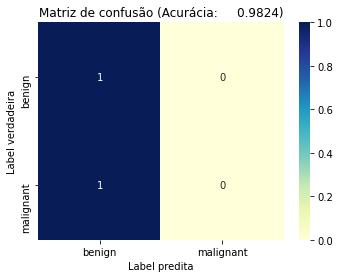

In [ ]:
# Mostra a matriz de confusão dos dados de validação
plot_confusion_matrix(pd.get_dummies(y_valid).values.argmax(axis=1),
                      validation_predictions.argmax(axis=1),['benign', 'malignant'], "Matriz de confusão")

É possível observar que o modelo não classificou nenhum exemplo como 'malignant'. Isso provavelmente se deve ao tamanho bastante reduzido das imagens, o uso da acurácia como métrica do modelo em uma base desbalanceada e, principalmente, ao enorme desbalanceamento da base de dados em si.

Para fazer a submissão, inferimos os dados de teste.

In [ ]:
# Teste

X_test = test_data.drop(columns=['image_name', 'patient_id'])

test_sex = X_test['sex'].str.get_dummies()
test_anatom = X_test['anatom_site_general_challenge'].str.get_dummies()

X_test = X_test.join([test_sex, test_anatom])

X_test.drop(columns=['sex', 'anatom_site_general_challenge'], inplace=True)

test_columns = X_test.columns

for column in train_columns:
    if column not in test_columns:
        X_test[column] = 0


gen_test = MixedDataGenerator(values=X_test,
                            images=test_data['image_name'],
                            directory='test',
                            target_size=(32, 32),
                            batch_size=32)


predictions = model.predict(gen_test,
                            verbose=1,
                            workers=16)


# predictions é um vetor em que cada elemento é um vetor de dois valores, já que temos duas classes (benigno e maligno).
# Pega-se então a probabilidade do tumor ser maligno
submission = pd.DataFrame(test_data['image_name'].str.replace(r'.jpg', ''))
submission['target']=predictions[:,1]

# Cria arquivo de submissão
submission.to_csv('multi_input_submission.csv',index=False)

344/344 [==============================] - 100s 291ms/step


O score oficial dessa submissão foi 0.499.

### Segunda submissão

Para uma nova submissão, algumas mudanças foram feitas a fim de tentar melhorar a classificação do modelo. 

Primeiramente, as imagens foram carregadas com uma resolução de 128x128 pixels

In [ ]:
# Leitura dos dataframes dos arquivos csv
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Adicionando a extensão aos nomes das imagens
train_data['image_name'] = train_data['image_name'].astype(str)+".jpg"
test_data['image_name'] = test_data['image_name'].astype(str)+".jpg"

train_data = treatNan(train_data)
test_data = treatNan(test_data)


# Separa os dados em treinamento e validação mantendo a proporção entre classes 'benign' e 'malignant'
train_data_ben = train_data[train_data.benign_malignant == 'benign']
train_data_mal = train_data[train_data.benign_malignant == 'malignant']

valid_data_ben = train_data_ben.sample(frac=0.3, random_state=1)
valid_data_mal = train_data_mal.sample(frac=0.3, random_state=1)

valid_data = valid_data_ben.append(valid_data_mal)

train_data.drop(index=valid_data.index)

valid_data = valid_data.reindex(np.random.permutation(valid_data.index))
valid_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)


# Rótulos dos dados
y_train = train_data.benign_malignant
y_valid = valid_data.benign_malignant

# Dados com atributos para o treinamento
X_train = train_data[['sex', 'age_approx', 'anatom_site_general_challenge']]
X_valid = valid_data[['sex', 'age_approx', 'anatom_site_general_challenge']]


train_sex = X_train['sex'].str.get_dummies()
train_anatom = X_train['anatom_site_general_challenge'].str.get_dummies()

valid_sex = X_valid['sex'].str.get_dummies()
valid_anatom = X_valid['anatom_site_general_challenge'].str.get_dummies()

X_train = X_train.join([train_sex, train_anatom])
X_valid = X_valid.join([valid_sex, valid_anatom])

X_train.drop(columns=['sex', 'anatom_site_general_challenge'], inplace=True)
X_valid.drop(columns=['sex', 'anatom_site_general_challenge'], inplace=True)

train_columns = X_train.columns
valid_columns = X_valid.columns

for column in valid_columns:
    if column not in train_columns:
        X_train[column] = 0

for column in train_columns:
    if column not in valid_columns:
        X_valid[column] = 0

gen_train = MixedDataGenerator(values=X_train,
                            images=train_data['image_name'],
                            directory='train',
                            labels=y_train,
                            target_size=(128,128),
                            batch_size=32)
gen_valid = MixedDataGenerator(values=X_valid,
                            images=valid_data['image_name'],
                            directory='train',
                            labels=y_valid,
                            target_size=(128,128),
                            batch_size=32)

Nesse modelo, foi usada a área abaixo da curva ROC como métrica de avaliação em vez da acurácia.

In [ ]:
#Criação do modelo multi-Input

mlp = createMLP(dimension=len(X_train.columns))
cnn = createCNN((128,128,3))

combinedInput = concatenate([cnn.output, mlp.output])

x = Dense(units=4, activation="relu")(combinedInput)
x = Dense(units=2, activation="sigmoid")(x)

model = Model(inputs=[cnn.input, mlp.input], outputs=x)

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [AUC()])

Além disso, como uma tentativa de compensar o desbalanceamento da base, foram definidos pesos para cada classe, utilizando a função [compute_class_weight()](https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html?highlight=class_weight#sklearn.utils.class_weight.compute_class_weight) do ScikitLearn.

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weights = dict(zip([0,1], class_weights))

In [ ]:
# Treinamento
model.fit(gen_train,
          epochs=4,
          validation_data=gen_valid,
          class_weight=class_weights,
          workers=16)
model.save_weights('cnn_melanoma.h5')

Epoch 1/4
1034/1034 [==============================] - 394s 381ms/step - loss: 0.6933 - auc: 0.4124 - val_loss: 0.6920 - val_auc: 0.5000
Epoch 2/4
1034/1034 [==============================] - 391s 378ms/step - loss: 0.6933 - auc: 0.3715 - val_loss: 0.6914 - val_auc: 0.5000
Epoch 3/4
1034/1034 [==============================] - 390s 378ms/step - loss: 0.6933 - auc: 0.5553 - val_loss: 0.6912 - val_auc: 0.5000
Epoch 4/4
1034/1034 [==============================] - 392s 380ms/step - loss: 0.6933 - auc: 0.8064 - val_loss: 0.6922 - val_auc: 0.5000


In [ ]:
# Validação

validation_predictions = model.predict(gen_valid,
                                       verbose=1,
                                       workers=16)

310/310 [==============================] - 89s 288ms/step


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9742
           1       0.00      0.00      0.00       175

   micro avg       0.98      0.98      0.98      9917
   macro avg       0.49      0.50      0.50      9917
weighted avg       0.97      0.98      0.97      9917
 samples avg       0.98      0.98      0.98      9917



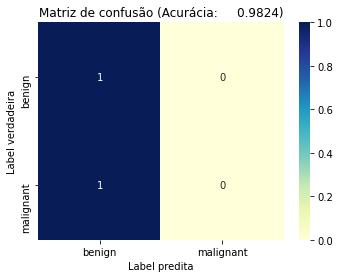

In [ ]:
validation_predictions = (validation_predictions > 0.5)


# class_labels = list(validation_generator.class_indices.keys())
# validation_true = validation_generator.classes

# Faz o classification report do modelo aplicado nos dados de validação
from sklearn.metrics import classification_report
report = classification_report(pd.get_dummies(y_valid),
                               validation_predictions)
print(report)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Plota a matriz de confusão dos dados de validação
plot_confusion_matrix(pd.get_dummies(y_valid).values.argmax(axis=1),
                      validation_predictions.argmax(axis=1),['benign', 'malignant'], "Matriz de confusão")

In [ ]:
# Teste

X_test = test_data.drop(columns=['image_name', 'patient_id'])

test_sex = X_test['sex'].str.get_dummies()
test_anatom = X_test['anatom_site_general_challenge'].str.get_dummies()

X_test = X_test.join([test_sex, test_anatom])

X_test.drop(columns=['sex', 'anatom_site_general_challenge'], inplace=True)

test_columns = X_test.columns

for column in train_columns:
    if column not in test_columns:
        X_test[column] = 0


gen_test = MixedDataGenerator(values=X_test,
                            images=test_data['image_name'],
                            directory='test',
                            target_size=(128, 128),
                            batch_size=32)


predictions = model.predict(gen_test,
                            verbose=1,
                            workers=16)


# predictions é um vetor em que cada elemento é um vetor de dois valores, já que temos duas classes (benigno e maligno).
# Pega-se então a probabilidade do tumor ser maligno
submission = pd.DataFrame(test_data['image_name'].str.replace(r'.jpg', ''))
submission['target']=predictions[:,1]

# Cria arquivo de submissão
submission.to_csv('multi_input_submission2.csv',index=False)

344/344 [==============================] - 101s 295ms/step


O score oficial dessa submissão foi 0.500.

Após a submissão dos resultados, o score obtido foi ligeiramente maior. Contudo, a diferença não foi significativa, o que nos faz perceber que o uso de pesos para as classes ainda não foi suficiente para compensar o grande desbalanceamento da base de dados.

Além disso, comparando o modelo multi-input com a CNN, observamos que utilizar as características dos pacientes contidas no dataframe não gerou um ganho de informação suficiente a ponto de melhorar significativamente a capacidade de classificação do modelo para essa base de dados.